<a href="https://colab.research.google.com/github/gregorio-ferreira/LLMs_PromptEng/blob/main/gdrive_copy_colab_image_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🔍 Image Research Platform - Google Colab Edition

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gregorio-ferreira/twins-images-research/blob/main/notebooks/colab_image_search.ipynb)

This notebook provides comprehensive image analysis using **Google Cloud Vision API** and **Knowledge Graph Search API** in Google Colab.

## 🎯 Features
- **Dual AI-Powered Analysis**: Vision API + Knowledge Graph
- **Flexible Search Modes**: Single image, batch processing, or URL lists
- **Professional Reports**: Generate "About this image" HTML reports
- **Timeline Research**: Web archive integration for historical analysis
- **Easy Setup**: No local installation required!

## 🚀 Quick Start
1. Run the setup cells below
2. Upload your Google Cloud credentials
3. Configure your search settings
4. Upload images or provide URLs
5. Execute the search!

---

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. 📦 Installation & Setup

First, let's install the required packages and clone the repository:

In [7]:
# Install required packages
!pip install google-cloud-vision google-auth google-auth-oauthlib
!pip install pandas numpy pyarrow PyYAML matplotlib seaborn plotly
!pip install google-api-python-client requests

print("✅ All packages installed successfully!")

✅ All packages installed successfully!


In [8]:
import sys
sys.path.append('/content/drive/MyDrive/TwinsImageResearch/twins/src')

print("✅ Python path configured!")

✅ Python path configured!


## 2. 🔐 Authentication Setup

You'll need:
1. **Google Cloud Service Account JSON file** (for Vision API)
2. **Knowledge Graph API Key** (from Google Cloud Console)

### 📋 Prerequisites:
- Google Cloud Project with Vision API and Knowledge Graph API enabled
- Service account with Vision API permissions
- API key for Knowledge Graph Search API

**📖 Setup Guide**: See the [README.md](https://github.com/gregorio-ferreira/twins-images-research#2-google-cloud-setup) for detailed instructions.

In [10]:
from google.colab import files
import json
import os

# print("📁 Please upload your Google Cloud Service Account JSON file:")
# print("   (This file should be named something like 'your-project-xxxxx.json')")

# uploaded = files.upload()

# Find the uploaded JSON file
credentials_file = "drive/MyDrive/TwinsImageResearch/twins/credentials.json"
# for filename in uploaded.keys():
#     if filename.endswith('.json'):
#         credentials_file = filename
#         break

if credentials_file:
    # Set environment variable for Google Cloud authentication
    os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = f'/content/{credentials_file}'
    print(f"✅ Credentials file '{credentials_file}' uploaded and configured!")

    # Verify the credentials
    try:
        from google.auth import default
        credentials, project_id = default()
        print(f"✅ Authentication successful! Project ID: {project_id}")
    except Exception as e:
        print(f"❌ Authentication failed: {e}")
else:
    print("❌ No JSON file found. Please upload your service account credentials.")

✅ Credentials file 'drive/MyDrive/TwinsImageResearch/twins/credentials.json' uploaded and configured!
✅ Authentication successful! Project ID: inlaid-hope-472305-s6


In [11]:
# # Configure API keys and settings
# import getpass

# print("🔑 Enter your Knowledge Graph API Key:")
# print("   (Get this from Google Cloud Console → APIs & Services → Credentials)")
# KNOWLEDGE_GRAPH_API_KEY = getpass.getpass("API Key: ")

# # Get project ID from credentials
# try:
#     from google.auth import default
#     credentials, PROJECT_ID = default()
#     print(f"✅ Using Google Cloud Project: {PROJECT_ID}")
# except:
#     PROJECT_ID = input("Enter your Google Cloud Project ID: ")

# # Create configuration
# config = {
#     'google_cloud': {
#         'project_id': PROJECT_ID,
#         'vision_api': {
#             'credentials_file': f'/content/{credentials_file}'
#         },
#         'knowledge_graph_api': {
#             'api_key': KNOWLEDGE_GRAPH_API_KEY
#         }
#     },
#     'database': {
#         'vision_analytics_db': '/content/drive/MyDrive/TwinsImageResearch/twins/vision_analytics.db'
#     },
#     'image_processing': {
#         'max_results': 20,
#         'supported_formats': ['.jpg', '.jpeg', '.png', '.gif', '.bmp', '.webp', '.tiff', '.tif']
#     }
# }

# # Save config to file
# import yaml
# with open('/content/drive/MyDrive/TwinsImageResearch/twins/config.yaml', 'w') as f:
#     yaml.dump(config, f)

# print("✅ Configuration saved successfully!")

🔑 Enter your Knowledge Graph API Key:
   (Get this from Google Cloud Console → APIs & Services → Credentials)


KeyboardInterrupt: Interrupted by user

## 3. 📚 Import Libraries and Initialize Database

In [12]:
# Core imports
import sys
import os
import sqlite3
from pathlib import Path
from datetime import datetime
from typing import Dict, Any, List, Optional
import hashlib
import base64
import requests
from urllib.parse import urlparse

# Data analysis
import pandas as pd
import numpy as np
import yaml
import json

# Google Cloud APIs
from google.cloud import vision
from google.auth import default
from googleapiclient.discovery import build

# Import our custom database module
from image_research import VisionAnalyticsDB

# Display
from IPython.display import display, HTML, Image as IPImage

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


In [15]:
# Initialize the database
CONFIG_PATH = '/content/drive/MyDrive/TwinsImageResearch/twins/config.yaml'

# Load configuration
with open(CONFIG_PATH, 'r') as f:
    config = yaml.safe_load(f)

# Initialize database connection
db = VisionAnalyticsDB(str(config['database']['vision_analytics_db']))

print(f"✅ Database initialized at: {str(config['database']['vision_analytics_db'])}")
print(f"✅ Configuration loaded from: {CONFIG_PATH}")
print(f"✅ Google Cloud Project: {config['google_cloud']['project_id']}")

✅ Database initialized at: /content/drive/MyDrive/TwinsImageResearch/twins/vision_analytics.db
✅ Configuration loaded from: /content/drive/MyDrive/TwinsImageResearch/twins/config.yaml
✅ Google Cloud Project: inlaid-hope-472305-s6


## 4. ⚙️ Search Configuration

Configure your search settings here:

In [16]:
# ===== SEARCH CONFIGURATION =====

# Search Mode Options:
# "single"    - Search one specific image
# "upload"    - Upload and search images from your computer
# "urls"      - Search images from URLs
# "directory" - Use images in a single directory
SEARCH_MODE = "upload"  # Change this to your preferred mode

# Feature toggles
ENABLE_KNOWLEDGE_GRAPH = True  # Enable Knowledge Graph API for detailed entity info
FORCE_NEW_SEARCH = False       # Set True to re-search existing images
MAX_RESULTS = 20               # Maximum results per search

# URL list (only used if SEARCH_MODE = "urls")
IMAGE_URLS = [
    "https://example.com/image1.jpg",
    "https://example.com/image2.png"
]

print(f"🔧 Search mode: {SEARCH_MODE}")
print(f"🧠 Knowledge Graph: {'Enabled' if ENABLE_KNOWLEDGE_GRAPH else 'Disabled'}")
print(f"📊 Max results per search: {MAX_RESULTS}")
print("\n✅ Configuration ready!")

🔧 Search mode: upload
🧠 Knowledge Graph: Enabled
📊 Max results per search: 20

✅ Configuration ready!


## 5. 📁 Image Upload & Preparation

Upload your images or provide URLs:

📁 Upload your images:
   Supported formats: .jpg, .jpeg, .png, .gif, .bmp, .webp, .tiff, .tif


Saving _125339033_gettyimages-109685978.jpg to _125339033_gettyimages-109685978.jpg
✅ Uploaded: _125339033_gettyimages-109685978.jpg

📊 Total images uploaded: 1

🖼️ Preview of uploaded images:


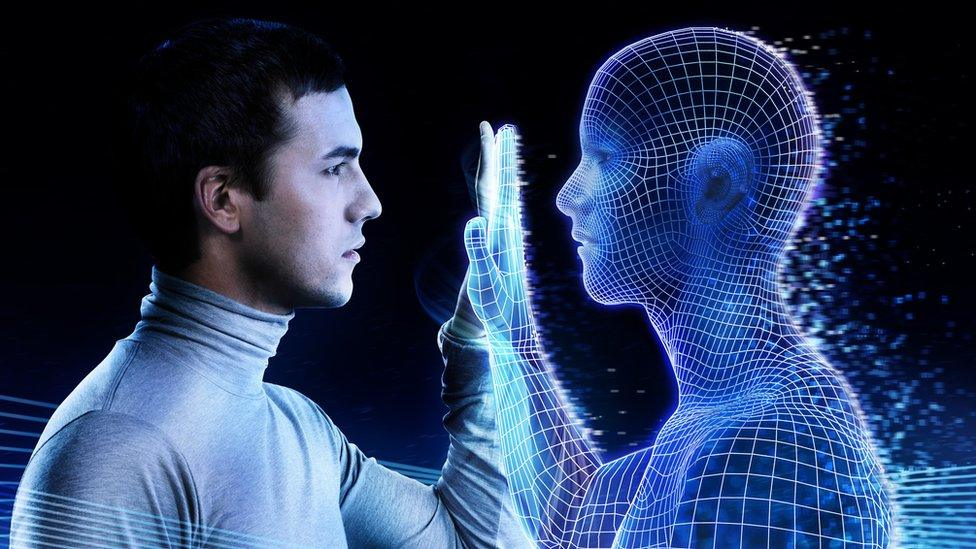

📁 _125339033_gettyimages-109685978.jpg


In [17]:
from google.colab import files
import shutil

# Create directory for uploaded images
upload_dir = '/content/drive/MyDrive/TwinsImageResearch/twins/images'
os.makedirs(upload_dir, exist_ok=True)

processed_images = []

if SEARCH_MODE == "upload":
    print("📁 Upload your images:")
    print("   Supported formats: .jpg, .jpeg, .png, .gif, .bmp, .webp, .tiff, .tif")

    uploaded = files.upload()

    for filename, content in uploaded.items():
        # Save uploaded file
        file_path = os.path.join(upload_dir, filename)
        with open(file_path, 'wb') as f:
            f.write(content)

        processed_images.append(file_path)
        print(f"✅ Uploaded: {filename}")

    print(f"\n📊 Total images uploaded: {len(processed_images)}")

elif SEARCH_MODE == "urls":
    print("🌐 Processing URLs:")
    for i, url in enumerate(IMAGE_URLS, 1):
        print(f"   {i}. {url}")
        processed_images.append(url)

    print(f"\n📊 Total URLs to process: {len(processed_images)}")

else:
    print("⚠️ Please set SEARCH_MODE to 'upload' or 'urls' in the configuration cell above.")

# Display uploaded images (for local files only)
if SEARCH_MODE == "upload" and processed_images:
    print("\n🖼️ Preview of uploaded images:")
    for img_path in processed_images[:5]:  # Show first 5 images
        try:
            display(IPImage(filename=img_path, width=200))
            print(f"📁 {os.path.basename(img_path)}")
        except Exception as e:
            print(f"❌ Could not display {img_path}: {e}")

## 6. 🔍 Search Execution

Now let's search your images using both Vision API and Knowledge Graph:

In [19]:
import time
from tqdm import tqdm
from google.cloud import vision
import requests

def search_knowledge_graph(query: str, api_key: str) -> dict:
    """Search Knowledge Graph API for entity information"""
    try:
        url = "https://kgsearch.googleapis.com/v1/entities:search"
        params = {
            'query': query,
            'limit': 1,
            'indent': True,
            'key': api_key
        }

        response = requests.get(url, params=params)

        if response.status_code == 200:
            return response.json()
        else:
            print(f"  ⚠️  Knowledge Graph API error {response.status_code}: {response.text}")
            return None

    except Exception as e:
        print(f"  ❌ Knowledge Graph error: {e}")
        return None

def process_single_image(image_path_or_url, db, enable_kg=True, max_results=20):
    """Process a single image with both Vision API and Knowledge Graph"""
    try:
        print(f"\n🔍 Processing: {os.path.basename(image_path_or_url) if not image_path_or_url.startswith('http') else image_path_or_url}")

        # Check for existing searches
        existing_searches = db.check_existing_search(image_path_or_url)

        if existing_searches and not FORCE_NEW_SEARCH:
            print(f"  ⏭️  Already searched {len(existing_searches)} times - skipping")
            return existing_searches[0]['search_id'], 0

        # Initialize Vision API client
        from google.cloud import vision
        from google.auth import default

        credentials, project_id = default()
        vision_client = vision.ImageAnnotatorClient(credentials=credentials)

        # Prepare image for Vision API
        if image_path_or_url.startswith(("http://", "https://", "gs://")):
            image = vision.Image()
            image.source.image_uri = image_path_or_url
            image_filename = os.path.basename(image_path_or_url)
            image_size = None
            image_format = os.path.splitext(image_path_or_url)[1]
        else:
            # Local file
            if not os.path.exists(image_path_or_url):
                print(f"  ❌ File not found: {image_path_or_url}")
                return None, 0

            with open(image_path_or_url, "rb") as f:
                content = f.read()
                image = vision.Image(content=content)

            image_filename = os.path.basename(image_path_or_url)
            image_size = len(content)
            image_format = os.path.splitext(image_path_or_url)[1]

        # Perform Vision API call
        response = vision_client.web_detection(image=image, max_results=max_results)

        if response.error.message:
            print(f"  ❌ Vision API error: {response.error.message}")
            return None, 0

        print(f"  ✅ Vision API completed")

        # Store search metadata
        search_data = {
            'timestamp': datetime.now(),
            'image_path': image_path_or_url,
            'image_filename': image_filename,
            'image_size_bytes': image_size,
            'image_format': image_format,
            'project_id': config['google_cloud']['project_id'],
            'max_results': max_results,
            'api_version': 'v1'
        }

        search_id = db.add_search(search_data)

        # Process and store Vision API results
        results_count = 0
        result_types = {}

        # Web entities
        if response.web_detection.web_entities:
            count = 0
            for rank, entity in enumerate(response.web_detection.web_entities, 1):
                result_data = {
                    'result_type': 'web_entity',
                    'result_rank': rank,
                    'entity_id': entity.entity_id,
                    'description': entity.description,
                    'score': entity.score
                }
                db.add_result(search_id, result_data)
                count += 1
                results_count += 1
            result_types['web_entity'] = count

        # Pages with matching images
        if response.web_detection.pages_with_matching_images:
            count = 0
            for rank, page in enumerate(response.web_detection.pages_with_matching_images, 1):
                result_data = {
                    'result_type': 'matching_page',
                    'result_rank': rank,
                    'url': page.url,
                    'page_title': page.page_title if hasattr(page, 'page_title') else None
                }
                db.add_result(search_id, result_data)
                count += 1
                results_count += 1
            result_types['matching_page'] = count

        # Full matching images
        if response.web_detection.full_matching_images:
            count = 0
            for rank, image_url in enumerate(response.web_detection.full_matching_images, 1):
                result_data = {
                    'result_type': 'full_match',
                    'result_rank': rank,
                    'url': image_url.url
                }
                db.add_result(search_id, result_data)
                count += 1
                results_count += 1
            result_types['full_match'] = count

        # Partial matching images
        if response.web_detection.partial_matching_images:
            count = 0
            for rank, image_url in enumerate(response.web_detection.partial_matching_images, 1):
                result_data = {
                    'result_type': 'partial_match',
                    'result_rank': rank,
                    'url': image_url.url
                }
                db.add_result(search_id, result_data)
                count += 1
                results_count += 1
            result_types['partial_match'] = count

        # Visually similar images
        if response.web_detection.visually_similar_images:
            count = 0
            for rank, image_url in enumerate(response.web_detection.visually_similar_images, 1):
                result_data = {
                    'result_type': 'visually_similar',
                    'result_rank': rank,
                    'url': image_url.url
                }
                db.add_result(search_id, result_data)
                count += 1
                results_count += 1
            result_types['visually_similar'] = count

        # Best guess labels
        if response.web_detection.best_guess_labels:
            count = 0
            for rank, label in enumerate(response.web_detection.best_guess_labels, 1):
                result_data = {
                    'result_type': 'best_guess_label',
                    'result_rank': rank,
                    'description': label.label
                }
                db.add_result(search_id, result_data)
                count += 1
                results_count += 1
            result_types['best_guess_label'] = count

        print(f"  📊 Vision results: {results_count} total ({result_types})")

        # Knowledge Graph search
        if enable_kg and ENABLE_KNOWLEDGE_GRAPH:
            # Determine primary entity for Knowledge Graph search
            primary_entity = None
            if response.web_detection.best_guess_labels:
                primary_entity = response.web_detection.best_guess_labels[0].label
            elif response.web_detection.web_entities:
                primary_entity = response.web_detection.web_entities[0].description

            if primary_entity:
                print(f"  🧠 Searching Knowledge Graph for: '{primary_entity}'")
                kg_response = search_knowledge_graph(primary_entity, config['google_cloud']['knowledge_graph_api']['api_key'])

                if kg_response:
                    db.add_knowledge_graph_result(search_id, kg_response)
                    print(f"  ✅ Knowledge Graph results stored")
                else:
                    print(f"  ⚠️  No Knowledge Graph results found")
            else:
                print(f"  ⚠️  No primary entity found for Knowledge Graph search")

        return search_id, results_count

    except Exception as e:
        print(f"  ❌ Error processing image: {e}")
        return None, 0

# Process all images
if processed_images:
    print(f"🚀 Starting search for {len(processed_images)} images...")
    print(f"⚙️ Vision API + {'Knowledge Graph API' if ENABLE_KNOWLEDGE_GRAPH else 'Vision API only'}")

    search_results = []
    total_results = 0

    for i, image in enumerate(processed_images, 1):
        print(f"\n📍 Progress: {i}/{len(processed_images)}")

        search_id, result_count = process_single_image(
            image, db,
            enable_kg=ENABLE_KNOWLEDGE_GRAPH,
            max_results=MAX_RESULTS
        )

        if search_id:
            search_results.append({
                'search_id': search_id,
                'image': image,
                'result_count': result_count
            })
            total_results += result_count

        # Small delay to be respectful to APIs
        if i < len(processed_images):
            time.sleep(1)

    print(f"\n🎉 Search completed!")
    print(f"📊 Total searches: {len(search_results)}")
    print(f"📊 Total results: {total_results}")
    print(f"📊 Average results per image: {total_results/len(search_results):.1f}" if search_results else "")

    # Store search results for later use
    LATEST_SEARCH_RESULTS = search_results

else:
    print("❌ No images to process. Please upload images or configure URLs first.")

🚀 Starting search for 1 images...
⚙️ Vision API + Knowledge Graph API

📍 Progress: 1/1

🔍 Processing: _125339033_gettyimages-109685978.jpg
  ✅ Vision API completed
  📊 Vision results: 95 total ({'web_entity': 14, 'matching_page': 20, 'full_match': 20, 'partial_match': 20, 'visually_similar': 20, 'best_guess_label': 1})
  🧠 Searching Knowledge Graph for: 'ai digital twin'
  ✅ Knowledge Graph results stored

🎉 Search completed!
📊 Total searches: 1
📊 Total results: 95
📊 Average results per image: 95.0


## 7. 📊 Search Results Summary

Let's examine what we found:

In [20]:
# Display search results summary
if 'LATEST_SEARCH_RESULTS' in locals() and LATEST_SEARCH_RESULTS:
    print("📋 SEARCH RESULTS SUMMARY")
    print("=" * 50)

    for i, result in enumerate(LATEST_SEARCH_RESULTS, 1):
        image_name = os.path.basename(result['image']) if not result['image'].startswith('http') else result['image'][:50] + '...'
        print(f"\n{i}. {image_name}")
        print(f"   🆔 Search ID: {result['search_id']}")
        print(f"   📊 Results: {result['result_count']}")

        # Get entity information using direct SQL queries
        cursor = db.conn.execute("""
        SELECT we.description, we.score
        FROM results r
        JOIN web_entities we ON r.result_id = we.result_id
        WHERE r.search_id = ? AND we.description IS NOT NULL
        ORDER BY we.score DESC LIMIT 3
        """, (result['search_id'],))
        entities = cursor.fetchall()

        if entities:
            print(f"   🏷️ Top entities:")
            for entity in entities:
                print(f"      • {entity[0]} (score: {entity[1]:.3f})")

        # Get Knowledge Graph information if available
        if ENABLE_KNOWLEDGE_GRAPH:
            cursor = db.conn.execute("""
            SELECT entity_name, entity_description
            FROM knowledge_graph_entities
            WHERE search_id = ?
            ORDER BY result_score DESC LIMIT 1
            """, (result['search_id'],))
            kg_results = cursor.fetchall()

            if kg_results:
                kg = kg_results[0]
                print(f"   🧠 Knowledge Graph: {kg[0]}")
                if kg[1]:
                    print(f"      {kg[1][:100]}..." if len(kg[1]) > 100 else f"      {kg[1]}")

    # Database overview
    print(f"\n\n📊 DATABASE OVERVIEW")
    print("=" * 30)

    # Total counts using direct SQL queries
    cursor = db.conn.execute("SELECT COUNT(*) FROM searches")
    total_searches = cursor.fetchone()[0]

    cursor = db.conn.execute("SELECT COUNT(*) FROM results")
    total_results = cursor.fetchone()[0]

    cursor = db.conn.execute("SELECT COUNT(*) FROM web_entities WHERE description IS NOT NULL")
    total_entities = cursor.fetchone()[0]

    print(f"🔍 Total searches: {total_searches}")
    print(f"📊 Total results: {total_results}")
    print(f"🏷️ Total entities: {total_entities}")

    if ENABLE_KNOWLEDGE_GRAPH:
        cursor = db.conn.execute("SELECT COUNT(*) FROM knowledge_graph_entities")
        total_kg = cursor.fetchone()[0]
        print(f"🧠 Knowledge Graph entities: {total_kg}")

else:
    print("❌ No search results available. Please run the search execution cell first.")

📋 SEARCH RESULTS SUMMARY

1. _125339033_gettyimages-109685978.jpg
   🆔 Search ID: search_20250921_100136_92f9a110
   📊 Results: 95
   🏷️ Top entities:
      • Digital twin (score: 0.981)
      • Artificial intelligence (score: 0.711)
      • Internet of Things (score: 0.675)


📊 DATABASE OVERVIEW
🔍 Total searches: 5
📊 Total results: 421
🏷️ Total entities: 72
🧠 Knowledge Graph entities: 2


## 8. 📋 Generate Professional Reports

Create "About this image" style reports with timeline research:

In [21]:
def generate_colab_image_report(search_id: str, db) -> str:
    """Generate comprehensive 'About this image' HTML report for Colab"""

    # Get search metadata using direct SQL query
    cursor = db.conn.execute("SELECT timestamp, image_filename, image_path FROM searches WHERE search_id = ?", (search_id,))
    search_results = cursor.fetchall()

    if not search_results:
        return f"<p>Search not found: {search_id}</p>"

    search_info = search_results[0]
    timestamp, image_filename, image_path = search_info

    # Get Knowledge Graph data
    cursor = db.conn.execute("""
    SELECT entity_name, entity_description, detailed_description, wikipedia_url, result_score
    FROM knowledge_graph_entities
    WHERE search_id = ?
    ORDER BY result_score DESC
    """, (search_id,))
    kg_results = cursor.fetchall()

    # Get Vision API results
    cursor = db.conn.execute("""
    SELECT we.description, we.score
    FROM results r
    JOIN web_entities we ON r.result_id = we.result_id
    WHERE r.search_id = ? AND we.description IS NOT NULL
    ORDER BY we.score DESC
    LIMIT 10
    """, (search_id,))
    entities = cursor.fetchall()

    # Get web pages
    cursor = db.conn.execute("""
    SELECT wp.url, wp.page_title
    FROM results r
    JOIN web_pages wp ON r.result_id = wp.result_id
    WHERE r.search_id = ?
    LIMIT 10
    """, (search_id,))
    web_pages = cursor.fetchall()

    # Get similar images
    cursor = db.conn.execute("""
    SELECT im.url
    FROM results r
    JOIN image_matches im ON r.result_id = im.result_id
    WHERE r.search_id = ? AND im.match_type = 'visually_similar'
    LIMIT 5
    """, (search_id,))
    similar_images = cursor.fetchall()

    # Build HTML report
    html_report = f"""
    <div style="font-family: Arial, sans-serif; max-width: 900px; margin: 20px auto; padding: 20px; border: 1px solid #ddd; border-radius: 10px;">
        <h1 style="color: #1a73e8;">📸 About This Image</h1>
        <p><strong>File:</strong> {image_filename or 'Unknown'}</p>
        <p><strong>Search performed:</strong> {timestamp}</p>
        <p><strong>Search ID:</strong> <code>{search_id}</code></p>
        <hr>
    """

    # Knowledge Graph information
    if kg_results:
        kg = kg_results[0]  # First (most relevant) result
        entity_name, entity_description, detailed_description, wikipedia_url, score = kg

        html_report += f"""
        <div style="background-color: #f8f9fa; padding: 15px; border-radius: 5px; margin: 15px 0;">
            <h2 style="color: #34a853;">🧠 {entity_name or 'Unknown Entity'}</h2>
            <p><strong>{entity_description or 'No description available.'}</strong></p>
        """

        if detailed_description:
            html_report += f"<p>{detailed_description}</p>"

        if wikipedia_url:
            html_report += f'<p><a href="{wikipedia_url}" target="_blank" style="color: #1a73e8;">📖 Read more on Wikipedia</a></p>'

        html_report += f"<p><em>Confidence score: {score:.3f}</em></p></div>"

    # Vision API entities
    if entities:
        html_report += "<h3 style='color: #ea4335;'>🏷️ Related Concepts</h3><ul>"
        for description, score in entities[:5]:
            html_report += f"<li>{description} <em>(confidence: {score:.3f})</em></li>"
        html_report += "</ul>"

    # Web pages with timeline research
    if web_pages:
        html_report += """
        <h3 style='color: #fbbc04;'>🌐 Web Pages with This Image - Timeline Research</h3>
        <div style="background-color: #e8f4fd; padding: 10px; border-radius: 5px; margin-bottom: 15px;">
            <strong>💡 Timeline Research Tips:</strong>
            <ul>
                <li>Use Wayback Machine to see when pages first appeared</li>
                <li>Check multiple archive dates to track image usage over time</li>
                <li>Look for the earliest archived version that contains this image</li>
            </ul>
        </div>
        """

        for i, (url, page_title) in enumerate(web_pages, 1):
            title = page_title if page_title else f"Page {i}"
            wayback_url = f"https://web.archive.org/web/*/{url}"
            wayback_first = f"https://web.archive.org/web/1/{url}"

            html_report += f"""
            <div style="margin-bottom: 15px; padding: 10px; border-left: 3px solid #4285f4; background-color: #fafafa;">
                <div><a href="{url}" target="_blank" style="font-weight: bold; color: #1a73e8;">{title}</a></div>
                <div style="font-size: 0.9em; color: #666; margin-top: 5px;">
                    📅 <a href="{wayback_url}" target="_blank" style="color: #1a73e8;">View archived versions</a> |
                    🎯 <a href="{wayback_first}" target="_blank" style="color: #1a73e8;">Find first capture</a>
                </div>
                <div style="font-size: 0.8em; color: #999; margin-top: 3px;">{url}</div>
            </div>
            """

    # Similar images
    if similar_images:
        html_report += "<h3 style='color: #9aa0a6;'>🔄 Visually Similar Images</h3>"
        html_report += '<div style="display: flex; flex-wrap: wrap; gap: 10px;">'
        for url_tuple in similar_images:
            url = url_tuple[0]
            html_report += f'<img src="{url}" style="height: 100px; border: 1px solid #ccc; border-radius: 5px;" onerror="this.style.display=\'none\'" title="{url}">'
        html_report += "</div>"

    html_report += "</div>"

    return html_report

In [22]:
# Generate reports for all searched images
if 'LATEST_SEARCH_RESULTS' in locals() and LATEST_SEARCH_RESULTS:
    print("📋 Generating professional reports...")

    reports_generated = []

    for result in LATEST_SEARCH_RESULTS:
        search_id = result['search_id']
        image_name = os.path.basename(result['image']) if not result['image'].startswith('http') else 'URL Image'

        print(f"\n📄 Generating report for: {image_name}")

        # Generate HTML report
        report_html = generate_colab_image_report(search_id, db)

        # Display the report
        print(f"\n🎨 Report for Search ID: {search_id}")
        display(HTML(report_html))

        # Save report to file
        report_filename = f"/content/report_{search_id[:20]}.html"
        with open(report_filename, 'w', encoding='utf-8') as f:
            f.write(f"""
            <!DOCTYPE html>
            <html>
            <head>
                <title>About This Image Report</title>
                <meta charset="utf-8">
            </head>
            <body>
                {report_html}
            </body>
            </html>
            """)

        reports_generated.append(report_filename)
        print(f"💾 Report saved to: {report_filename}")

    print(f"\n✅ Generated {len(reports_generated)} reports!")
    print("📁 You can download the HTML files from the Files panel on the left.")

else:
    print("❌ No search results available. Please run the search execution first.")

📋 Generating professional reports...

📄 Generating report for: _125339033_gettyimages-109685978.jpg

🎨 Report for Search ID: search_20250921_100136_92f9a110


💾 Report saved to: /content/report_search_20250921_1001.html

✅ Generated 1 reports!
📁 You can download the HTML files from the Files panel on the left.


## 9. 💾 Download Results

Download your database and reports:

In [ ]:
from google.colab import files
import zipfile

# Create a zip file with all results
zip_filename = f"/content/image_research_results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.zip"

with zipfile.ZipFile(zip_filename, 'w') as zipf:
    # Add database
    if os.path.exists(DATABASE_PATH):
        zipf.write(DATABASE_PATH, 'vision_analytics.db')
        print("✅ Added database to zip")

    # Add configuration
    if os.path.exists(CONFIG_PATH):
        zipf.write(CONFIG_PATH, 'config.yaml')
        print("✅ Added configuration to zip")

    # Add HTML reports
    report_files = [f for f in os.listdir('/content') if f.startswith('report_') and f.endswith('.html')]
    for report_file in report_files:
        zipf.write(f'/content/{report_file}', f'reports/{report_file}')
        print(f"✅ Added {report_file} to zip")

    # Add uploaded images
    if os.path.exists(upload_dir):
        for img_file in os.listdir(upload_dir):
            img_path = os.path.join(upload_dir, img_file)
            zipf.write(img_path, f'images/{img_file}')
        print(f"✅ Added uploaded images to zip")

print(f"\n📦 Created zip file: {zip_filename}")
print(f"📊 File size: {os.path.getsize(zip_filename) / 1024:.1f} KB")

# Download the zip file
print("\n⬇️ Downloading results...")
files.download(zip_filename)

## 10. 📊 Summary & Next Steps

### 🎉 What You've Accomplished:

1. **✅ Searched Images**: Used Google Cloud Vision API and Knowledge Graph API
2. **✅ Generated Reports**: Professional "About this image" HTML reports
3. **✅ Timeline Research**: Direct links to web archives for historical analysis
4. **✅ Downloaded Results**: Complete database and reports package

### 🔄 Continue Your Research:

- **📊 Analytics**: Open the [Analytics Colab notebook](https://colab.research.google.com/github/gregorio-ferreira/twins-images-research/blob/main/notebooks/colab_image_analytics.ipynb) to analyze your results
- **🔍 More Images**: Re-run this notebook with additional images
- **🕐 Timeline Analysis**: Use the archive links in your reports to track image history
- **💾 Local Setup**: Download and run the full project locally for advanced features

### 📚 Resources:

- **GitHub Repository**: [twins-images-research](https://github.com/gregorio-ferreira/twins-images-research)
- **Full Documentation**: See the README.md in the repository
- **Local Installation**: Follow the setup guide for your own environment

---

*🔬 Built for researchers, by researchers. Transform your image analysis workflow with AI-powered insights!*